In [4]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import logging
from os.path import join as pjoin
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt


In [5]:
wdir = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/pmwd/L1000-N128/3'
xyz = np.load(pjoin(wdir, 'halo_cuboid_pos.npy'))
vel = np.load(pjoin(wdir, 'halo_cuboid_vel.npy'))
mass = np.load(pjoin(wdir, 'halo_mass.npy'))

cosmo = [0.3271, 0.06875, 0.6313, 0.8135, 0.8939]
redshift = 0.5

## ngc_selection

In [12]:
import nbodykit.lab as nblab
def xyz_to_sky(pos, vel, cosmo):
    cosmology = nblab.cosmology.Planck15.clone(
        h=cosmo[2],
        Omega0_b=cosmo[1],
        Omega0_cdm=cosmo[0] - cosmo[1],
        m_ncdm=None,
        n_s=cosmo[3])

    # We don't need to match sigma8, because sky transform is invariant.
    # cosmology = cosmology.match(sigma8=cosmo[4])

    return nblab.transform.CartesianToSky(pos, cosmology, velocity=vel).T

rdz = xyz_to_sky(xyz, vel, cosmo).compute()
rdz[:2]

KeyboardInterrupt: 

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.cosmology as cosmology
from astropy.constants import c
from scipy.interpolate import interp1d
from copy import deepcopy

def xyz_to_sky(pos, vel, cosmo):
    """Converts cartesian coordinates to sky coordinates (ra, dec, z).
    Inspired by nbodykit.transform.CartesianToSky.
    """
    if isinstance(cosmo, list):
        cosmo = cosmology.FlatLambdaCDM(
            H0=cosmo[2]*100,
            Om0=cosmo[0],
            Ob0=cosmo[1],
        )  # sigma8 and ns are not needed

    pos /= cosmo.h  # convert from Mpc/h to Mpc
    pos *= u.Mpc  # label as Mpc
    vel *= u.km / u.s  # label as km/s

    # get ra, dec
    coord_cart = SkyCoord(
        x=pos[:, 0], y=pos[:, 1], z=pos[:, 2],
        representation_type='cartesian')
    coord_sphe = coord_cart.represent_as('spherical')
    ra = coord_sphe.lon.to(u.deg)
    dec = coord_sphe.lat.to(u.deg)

    # get redshift
    R = np.linalg.norm(pos, axis=-1)

    def z_from_comoving_distance(d):
        zgrid = np.logspace(-8, 1.5, 2048)
        zgrid = np.concatenate([[0.], zgrid])
        dgrid = cosmo.comoving_distance(zgrid)
        return interp1d(dgrid, zgrid)(d)

    # Convert comoving distance to redshift
    z = z_from_comoving_distance(R)

    vpec = (pos*vel).sum(axis=-1) / R
    z += vpec / c.to(u.km/u.s)*(1+z)

    return np.array([ra, dec, z]).T
ardz = xyz_to_sky(deepcopy(xyz), vel, cosmo)
ardz[:2]

array([[10.5274784 , 26.01275557,  0.52942388],
       [55.35880049, 32.34488454,  0.48389944]])

In [ ]:
from nbodykit.cosmology import Planck15
xyz = nblab.transform.SkyToCartesian(*rdz.T, Planck15).compute()
xyz[:2]

array([[1220.10292204,  226.73801164,  605.61430147],
       [ 612.16946655,  886.02642149,  681.99299695]])

In [ ]:

def sky_to_xyz(rdz, cosmo):
    """Converts sky coordinates (ra, dec, z) to cartesian coordinates."""
    if isinstance(cosmo, list):
        cosmo = cosmology.FlatLambdaCDM(
            H0=cosmo[2]*100,
            Om0=cosmo[0],
            Ob0=cosmo[1],
        )  # sigma8 and ns are not needed

    ra, dec, z = rdz.T
    pos = SkyCoord(ra=ra*u.deg, dec=dec*u.deg,
                   distance=cosmo.comoving_distance(z))
    pos = pos.cartesian.xyz.to(u.Mpc)
    pos *= cosmo.h  # convert from Mpc to Mpc/h

    return pos.value.T

from astropy.cosmology import Planck15
axyz = sky_to_xyz(rdz, Planck15)
axyz[:2]

array([[1220.10006552,  226.7374808 ,  605.6128836 ],
       [ 612.1681803 ,  886.02455984,  681.991564  ]])

## halo -> galaxies

In [ ]:
from halotools.sim_manager import UserSuppliedHaloCatalog
from astropy.cosmology import Planck15
L = 1000
z=0.5
BoxSize = L*np.array([np.sqrt(2), 1, 1/np.sqrt(2)])
Position = xyz
Velocity = vel
Mass = 10**mass
halo_id = np.arange(len(mass))

mkey = 'halo_mvir'
mdef = 'vir'
rkey = 'halo_rvir'

In [ ]:
from halotools.empirical_models import NFWProfile
kws = {'cosmology':Planck15, 'conc_mass_model':'dutton_maccio14', 'mdef':mdef}

def get_nfw_conc(mass, redshift):
    kw1 = {}
    kw1.update(kws)
    kw1['redshift'] = redshift
    model = NFWProfile(**kw1)
    return model.conc_NFWmodel(prim_haloprop=mass)

Concen = get_nfw_conc(Mass, z)

In [ ]:
from halotools.empirical_models import halo_mass_to_halo_radius
kws = {'cosmology':Planck15, 'mdef':mdef}

def mass_to_radius(mass, redshift):
    return halo_mass_to_halo_radius(mass=mass, redshift=redshift, **kws)

Rvir = mass_to_radius(Mass, z)

In [ ]:
type(Planck15)

astropy.cosmology.flrw.lambdacdm.FlatLambdaCDM

In [ ]:
# data columns
kws                  = {}
kws['halo_x']        = Position[:,0]
kws['halo_y']        = Position[:,1]
kws['halo_z']        = Position[:,2]
kws['halo_vx']       = Velocity[:,0]
kws['halo_vy']       = Velocity[:,1]
kws['halo_vz']       = Velocity[:,2]
kws[mkey]            = Mass
kws[rkey]            = Rvir
kws['halo_nfw_conc'] = Concen
kws['halo_id']       = halo_id
kws['halo_hostid']    = halo_id
kws['halo_upid']     = np.zeros(len(Position)) - 1
# kws['halo_local_id'] = np.arange(0, self.size, dtype='i8')

# add metadata too
kws['cosmology']     = Planck15
kws['redshift']      = z
kws['Lbox']          = BoxSize
kws['particle_mass'] = 1e9
kws['mdef']          = mdef

cat = UserSuppliedHaloCatalog(**kws)

In [ ]:
np.random.seed(15)
hod_lower_bound = np.array([12.0, 0.1, 13.0, 13.0, 0.])
hod_upper_bound = np.array([14.0, 0.6, 15.0, 15.0, 1.5])
keys = ['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha']
theta = np.random.uniform(hod_lower_bound, hod_upper_bound, size=(5))
theta = [float(x) for x in theta]
theta = dict(zip(keys, theta))
print(theta)

{'logMmin': 13.697635394537157, 'sigma_logM': 0.18944796246049925, 'logM0': 13.108726428612863, 'logM1': 13.723076892176445, 'alpha': 0.41310139290961795}


In [ ]:
from halotools.empirical_models import PrebuiltHodModelFactory
model = PrebuiltHodModelFactory('zheng07', threshold = -20, redshift=z, **theta)

In [ ]:
model.populate_mock(halocat = cat) 

In [ ]:
galcat = model.mock.galaxy_table.as_array()

In [ ]:
gxyz = np.vstack([galcat['x'], galcat['y'], galcat['z']]).T
gvel = np.vstack([galcat['vx'], galcat['vy'], galcat['vz']]).T

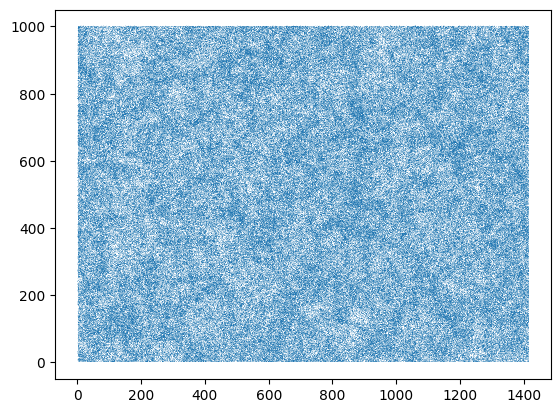

In [ ]:
import matplotlib.pyplot as plt
plt.plot(gxyz[:,0], gxyz[:,1], ',', alpha=0.1)

In [ ]:
mass

array([12.83319481, 12.94266332, 12.81945765, ..., 15.47999947,
       15.40776716, 15.42189628])

In [ ]:
# from scripts

import astropy.cosmology as cosmology
from cmass.bias.tools.hod import *
from cmass.bias.apply_hod import populate_hod

L = 1000
mdef = 'vir'

In [ ]:
if isinstance(cosmo, list):
    cosmo = cosmology.FlatLambdaCDM(
        H0=cosmo[2]*100,
        Om0=cosmo[0],
        Ob0=cosmo[1],
    )  # sigma8 and ns are not needed
BoxSize = L*np.array([np.sqrt(2), 1, 1/np.sqrt(2)])
catalog = build_halo_catalog(
    xyz, vel, 10**mass, redshift, BoxSize, cosmo,
    mdef=mdef
)

In [ ]:

hod_params = {}

hod = build_HOD_model(
    cosmo, redshift, hod_model='zheng07', mdef=mdef,
    **hod_params
)

hod.populate_mock(catalog, seed=0)

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:368: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)


In [ ]:


galcat = hod.mock.galaxy_table.as_array()

In [ ]:
galcat.dtype.names

('halo_rvir',
 'halo_hostid',
 'halo_vz',
 'halo_x',
 'conc_NFWmodel',
 'halo_vy',
 'halo_mvir',
 'halo_vx',
 'halo_id',
 'halo_z',
 'halo_y',
 'halo_upid',
 'halo_num_centrals',
 'halo_num_satellites',
 'gal_type',
 'x',
 'host_centric_distance',
 'vz',
 'z',
 'y',
 'vy',
 'vx')

## Power spectra

In [4]:
from cmass.summaries.Pk_nbkit import (
    load_randoms, compute_Pk, BOSS_area, sky_to_xyz,
    get_nofz)
from nbodykit import cosmology
cosmo = cosmology.Planck15

grdz = np.load(pjoin(wdir, 'obs', 'rdz2.npy'))
rrdz = load_randoms('../data')
gxyz = sky_to_xyz(grdz, cosmo)
rxyz = sky_to_xyz(rrdz, cosmo)

area = BOSS_area('../data')
fsky = area / (360.**2 / np.pi)
ng_of_z = get_nofz(grdz[:, -1], fsky, cosmo=cosmo)
nbar_g = ng_of_z(grdz[:, -1])
nbar_r = ng_of_z(rrdz[:, -1])

P0 = 1e5
gweight = 1./(1. + nbar_g * P0)
rweight = 1./(1. + nbar_r * P0)

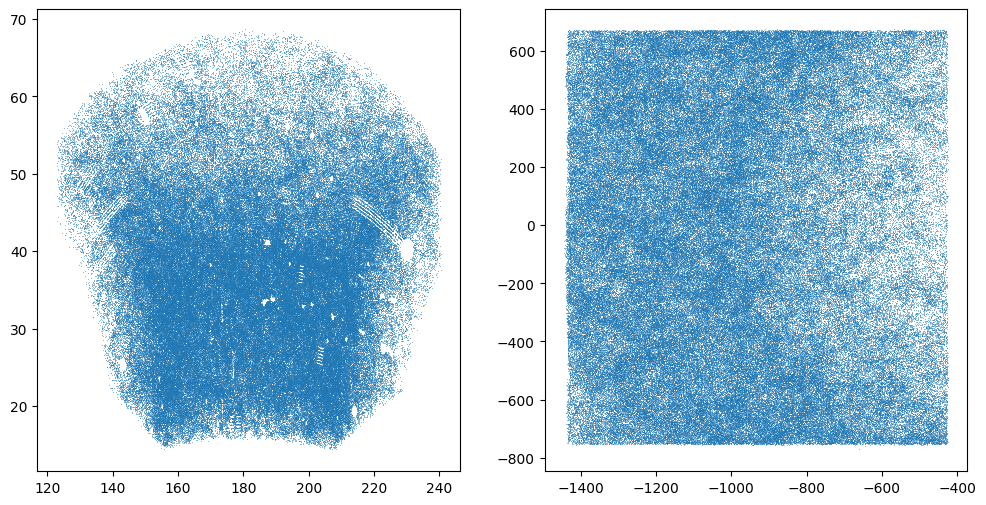

In [5]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(grdz[:,0], grdz[:,1], ',', alpha=0.5)
axs[1].plot(gxyz[:,0], gxyz[:,1], ',', alpha=0.5)

In [6]:
area =  BOSS_area('../data')
k, p0k, p2k, p4k = compute_Pk(grdz, rrdz, cosmo, area)

/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/mattho/git/nbodykit/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


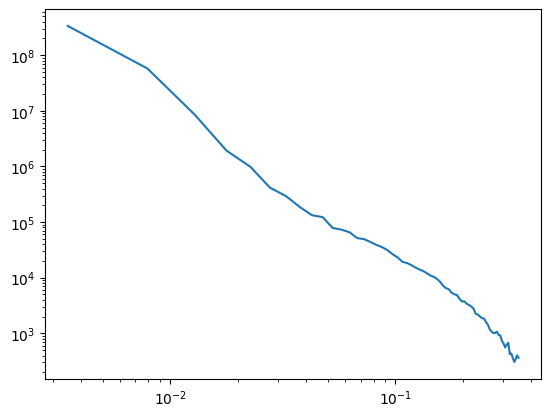

In [9]:
plt.loglog()
plt.plot(k, p0k, label='P0')

In [10]:
data_positions = gxyz
data_weights = gweight
randoms_positions = rxyz
randoms_weights = rweight

In [17]:
from pypower import CatalogFFTPower

kedges = np.arange(0, 2, 0.005)
poles = CatalogFFTPower(
    data_positions1=data_positions, data_weights1=data_weights, 
    randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
    nmesh=256, resampler='tsc', interlacing=2, 
    ells=(0, 2, 4), edges=kedges,
    position_type='pos', dtype='f4').poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise))
print('Normalization is {:.4f}.'.format(poles.wnorm))

[autoreload of cmass.utils.utils failed: Traceback (most recent call last):
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: wrapper() requires a code object with 1 free vars, not 0
]
[autoreload of cmass.survey.tools failed: Traceback (most recent call last):
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreloa

Shot noise is 12655.0224.
Normalization is 0.1855.


[autoreload of cmass.survey.tools failed: Traceback (most recent call last):
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/data80/mattho/anaconda3/envs/cmass/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/mattho/git/ltu-cmass/cmass/survey/tools.py", line 19, in <module>
    from ..utils import timing_decorator, cosmo_to_astropy
ImportError: cannot import name 'cosmo_to_astropy' from 'cmass.utils' (/home/mattho/git/ltu-cmass/cma

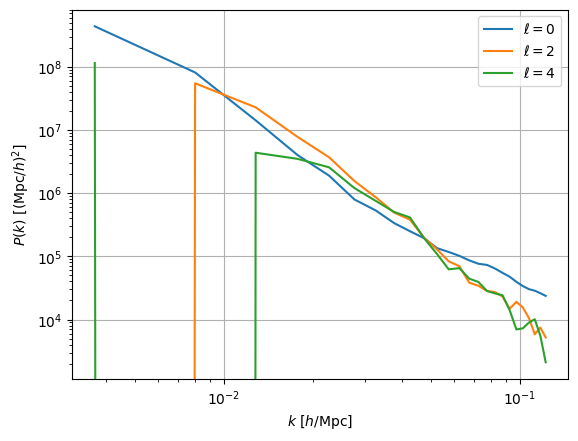

In [18]:
ax = plt.gca()
ax.loglog()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles(ell=ell, complex=False, 
                           remove_shotnoise=True), 
            label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

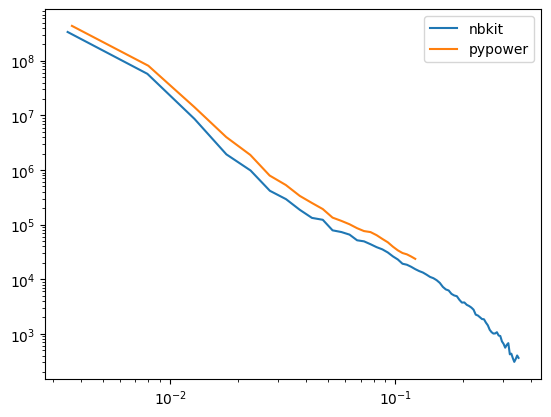

In [19]:
ell=0
p0k_pp = poles(
      ell=ell, complex=False, divide_wnorm=True,
      add_direct=False,
      null_zero_mode=False,
      remove_shotnoise=True)

# corr = p0k[5]/p0k_pp[5]

plt.loglog()
plt.plot(k, p0k, label='nbkit')
plt.plot(poles.k, p0k_pp,
        label='pypower')
plt.legend()

## Compare Outputs

In [12]:
wdir

'/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/pmwd/L1000-N128/3'

In [16]:
Pkp = np.load(pjoin(wdir, 'Pk', 'Pk0.npz'))
Pkn = np.load(pjoin(wdir+'-nbkit', 'Pk', 'Pk0_random_filter.npz'))

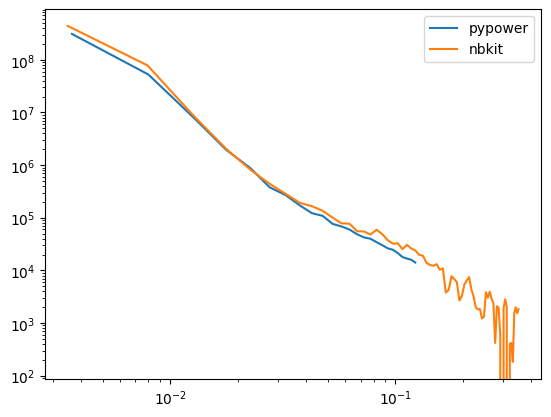

In [17]:

plt.loglog()
k, p0k = Pkp['k_gal'], Pkp['p0k_gal']
plt.plot(k, p0k, label='pypower')

k, p0k = Pkn['sk_gal'], Pkn['p0k_gal']
plt.plot(k, p0k, label='nbkit')
plt.legend()